Initial analysis on STEM01. Feature landscape, correlations, PCA, clustering, and comparison of differentiating features. Looked at the effect of flipping isogenic labels just in case they were labelled wrong in the experiment.

Conclusion: We can differentiate the controls from deletions in STEM01 with reasonable accuracy even without supervised methods. The isogenics make way more sense if you flip the labels though. 

In [1]:
import os
import pandas as pd
import numpy as np
import zipfile
import seaborn as sns 

import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
import matplotlib.patches as mpatches

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
from collections import Counter

from cytominer_eval import evaluate
from cytominer_eval.operations import grit
from pycytominer.cyto_utils import infer_cp_features, check_correlation_method 
# from pycytominermodz

# Functions

In [2]:
def load_data(path):
    """
    Loads the csv or csv.gz file into a pandas df, providing unique ID.
    """
    df = pd.read_csv(path)
    
    # Seperate data and metadata
    metadata_cols = [i for i in df.columns if 'Metadata' in i]
    metadata = df[metadata_cols]
    data_cols = [i for i in df.columns if i not in metadata_cols]
    
    # Remove exclude features from the data df
    data_cols = [x for x in data_cols if x.find('Costes')<0 if x.find('Manders')<0 if x.find('RWC')<0 
            if x.find('Parent')<0 if x.find('Object_Number')<0 if x.find('ObjectNumber')<0]
    data = df[data_cols]
    
    # Use metadata to create the index
    metadata_df = metadata.copy()
    data_df = data.copy()
    metadata_df['my_id'] = metadata['Metadata_line_source'] + '_' + metadata['Metadata_line_condition'] + '_' + \
        metadata['Metadata_line_ID'].astype(str) + '_' + metadata['Metadata_well_position']
    data_df['my_id'] = metadata_df['my_id']
    data_df.set_index('my_id', inplace=True)
    print('df shape: {}'.format(data_df.shape))
    
#     Remove the extraneous 'control' or 'deletion' for the isogenic perturbs, to keep naming consistency.
    new_idx = data_df.index.tolist()
    new_idx = [i.split('_')[0]+'_'+ i.split('_')[1]+'_'+ i.split('_')[3]+'_' +i.split('_')[4] \
               if 'genic' in i else i for i in new_idx]
    
    data_df.index = new_idx
    return data_df

def unstack_formatted_matrix(df, double=False):
    """
    df: a matrix which was the result of get_formatted_matrix
    double: whether to replicate the df and append, with id1 and id2 reversed. That way, all perturbs are represented in
        each id column, making finding non-group correlations easier
    returns: unstacked version of the matrix
    """
    
    # Unstacks the df and gets pairwise correlations for every perturbation instance
    unstack_agg_features_all = df.T.copy()
    unstack_agg_features_all = unstack_agg_features_all.corr(method='spearman')
    unstack_agg_features_all_tophalf = unstack_agg_features_all.where(np.triu(np.ones(unstack_agg_features_all.shape)).astype(np.bool))

    unstack_agg_all = unstack_agg_features_all_tophalf.unstack().reset_index()
    unstack_corrs_agg = unstack_agg_all.rename(columns={"level_0": "id1", "level_1": "id2", 0: "correlation"})
    # At this point, should be (384+383+...+3+2+1) = 73920 rows
    unstack_corrs_agg = unstack_corrs_agg[~unstack_corrs_agg['correlation'].isna()]
     
    # Replicate and append the dataframe, if double is True, so that each perturb is present in both cols. 
    # Should have 73920*2 cols.
    if double:
        repl = unstack_corrs_agg.copy()
        temp_id1 = repl['id1'].tolist()
        temp_id2 = repl['id2'].tolist()
        repl['id1'] = temp_id2
        repl['id2'] = temp_id1
        unstack_corrs_agg = unstack_corrs_agg.append(repl)

    # Remove correlations where id1 == id2 (same well), should have 73536(*2) rows
    unstack_corrs_agg = unstack_corrs_agg[unstack_corrs_agg['id1'] != unstack_corrs_agg['id2']]
    unstack_corrs_agg.reset_index(inplace=True, drop=True)     
    
    # Add columns to label unique perturbs
    unstack_corrs_agg['perturb1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['perturb2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1])
    unstack_corrs_agg['cell_line1'] = unstack_corrs_agg['id1'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    unstack_corrs_agg['cell_line2'] = unstack_corrs_agg['id2'].str.split('_').map(lambda x: x[0] + '_' + x[1] + '_' + x[2])
    return unstack_corrs_agg 

In [3]:
def hierarchical_cluster(df, threshold, show=False):
    """
    Returns df of cluster features
    """
    threshold=threshold
    Z1 = linkage(df, 'ward')
    flat_linkage1 = fcluster(Z1, t=threshold, criterion='distance')
    cluster_features1 = id_to_cluster(flat_linkage1, df)
    
    if show:
        plt.figure(figsize=(12, df.shape[0]/4))
        plt.axvline(x=threshold)
        label = [str(i) + ' ' + j for i, j in zip(flat_linkage1.tolist(), df.index.tolist())]
        plt.title('Clusters based on cell profiler features')
        dend1 = dendrogram(Z1, color_threshold=threshold, orientation='left', leaf_font_size=10, labels=label)
    return cluster_features1

def id_to_cluster(linkage_data, agg_features_df):
    """
    linkage_data: array of cluster numbers
    agg_features_df: df of aggregated features to merge, index must match order of linkage_data
    Returns a df with aggregated cp data and cluster number for each id
    """
    # Get cluster number with the aggregated feature data
    clusters_hierarchal_df = pd.DataFrame(data=linkage_data, index=agg_features_df.index)
    clusters_hierarchal_df.rename(columns={0:'cluster_num'}, inplace=True)
    clusters_hierarchal_df = clusters_hierarchal_df.merge(agg_features_df, how='left', left_index=True, right_index=True)

    # Get the cell profiler features by cluster
    cp_features_by_cluster = clusters_hierarchal_df.groupby(by='cluster_num').mean()
    
    return clusters_hierarchal_df

In [4]:
def ttest_2_df(df1, df2, alpha=0.05, reject_only=True):
    """
    Inputs are 2 dataframes with the same column features. Returns FDR adjusted p-values for each feature.
    """
#     assert df1.columns == df2.columns
    z_score, pvals = ttest_ind(df1.values, df2.values, axis=0)
    p_df = pd.DataFrame(pvals, index = df1.columns)
    p_df = p_df.rename(columns={0: 'pval'}) # unadjusted p values
    
    # Remove first row, which is just a ttest on the column number
    p_df =  p_df.iloc[1:]
    
    # Get corrected p-values
    q_df = p_df
    q_df['adj_p_value'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[1]
    q_df['reject_null'] = multipletests(p_df['pval'].values, alpha=alpha, method='fdr_bh')[0]
    
    if reject_only:
        q_df = q_df[q_df['reject_null'] == True]
    
    return q_df

# Feature set selection

In [5]:
from pathlib import Path
path = os.getcwd()
base_dir = str(Path(path).parent)

switch_isogenic_labels = True

# Normalized data, not var selected
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized.csv.gz')
# data_by_well = data_by_well.dropna(axis=1)

# Normalized var selected data, provided to me 
# data_by_well = load_data(base_dir + '/1.run-workflows/profiles/NCP_STEM_1/BR_NCP_STEM_1/BR_NCP_STEM_1_normalized_variable_selected.csv.gz')

# Or use my FS data
data_by_well = pd.read_csv(base_dir + '/3.analysis/feature_sets/STEM01/0621_stdev_corr_fs.csv', index_col=0)

data_by_well_orig = data_by_well.copy()

try:
    idx = [i for i in data_by_well.index.tolist() if i.split('_')[-1] not in exclude]
    data_by_well = data_by_well[data_by_well.index.isin(idx)]
except: pass

print ('shape: {}'.format(data_by_well.shape))

shape: (384, 559)


In [6]:
labels = data_by_well.index.tolist()
if switch_isogenic_labels:
    for i in range(len(labels)):
        if 'isogenic_deletion' in labels[i]:
            labels[i] = labels[i].replace('isogenic_deletion', 'temp')
    for i in range(len(labels)):
        if 'isogenic_control' in labels[i]:
            labels[i] = labels[i].replace('isogenic_control', 'isogenic_deletion')            
        if 'temp' in labels[i]:
            labels[i] = labels[i].replace('temp', 'isogenic_control')                    
data_by_well.index = labels

In [7]:
data_by_well_human = data_by_well[data_by_well.index.str.contains('human')]
data_by_well_iso = data_by_well[data_by_well.index.str.contains('isogenic')]

# Feature Landscape

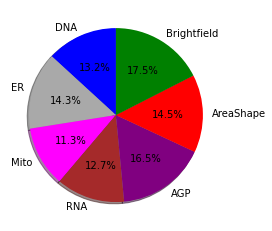

[83, 90, 71, 80, 104, 91, 110] 629


In [8]:
# Features by image channel
all_features = data_by_well.columns.tolist()
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]
fig1, ax1 = plt.subplots()
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()

print(sizes,sum(sizes))

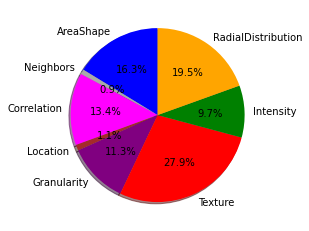

[91, 5, 75, 6, 63, 156, 54, 109] 559


In [9]:
# Features by feature type
all_features = data_by_well.columns.tolist()
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()
print(sizes,sum(sizes))

In [10]:
len([i for i in data_by_well.columns.tolist() if 'Texture' in i])

156

# Correlations

<ipython-input-11-756bd5acccd6>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


0.6009633643815191


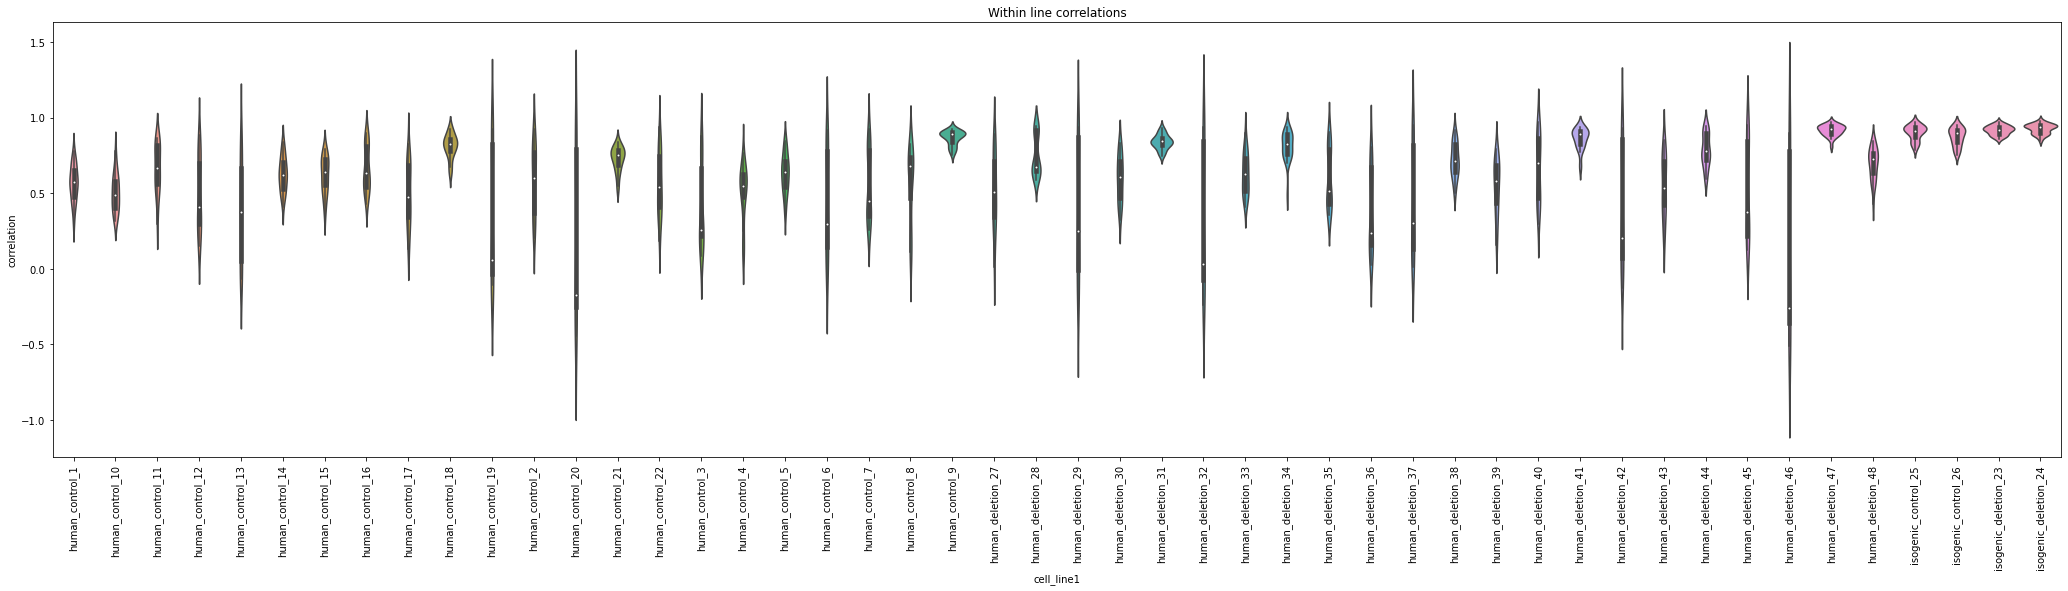

In [11]:
corrs = unstack_formatted_matrix(data_by_well)

# Get correlations within each cell line (8 replicates per)
corrs_within_line = corrs[corrs['cell_line1']==corrs['cell_line2']]

# Plot the self correlations
order = sorted(list(set(corrs_within_line['cell_line1'].tolist())))
fig, ax = plt.subplots(figsize=(36,8))
plt.title('Within line correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(x='cell_line1', y='correlation', data=corrs_within_line, order=order)

print(corrs_within_line['correlation'].mean())

<ipython-input-12-d894ad4784e7>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


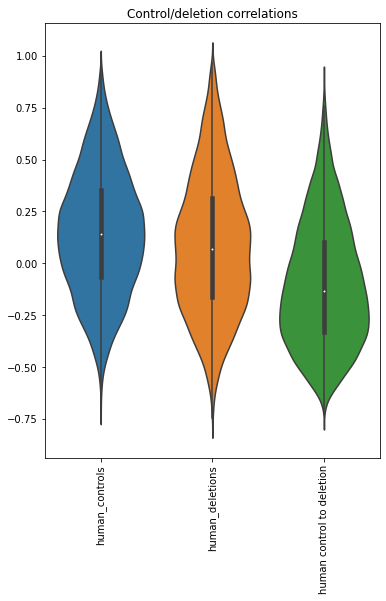

In [12]:
# Correlations between human controls, human deletion, and controls to deletion
corr_controls = corrs[(corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_control')]
corr_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_deletion')]
corr_control_to_deletion = corrs[(corrs['perturb1'] == 'human_deletion') & (corrs['perturb2'] == 'human_control') 
                                 | (corrs['perturb1'] == 'human_control') & (corrs['perturb2'] == 'human_deletion')]

to_df = [corr_controls['correlation'].tolist(), corr_deletion['correlation'].tolist(), corr_control_to_deletion['correlation'].tolist()]
corrs_controls_deletions = pd.DataFrame(to_df, index=['human_controls', 'human_deletions', 'human control to deletion']).T

# Plot the control/deletion correlations
fig, ax = plt.subplots(figsize=(6,8))
plt.title('Control/deletion correlations')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax = sns.violinplot(data=corrs_controls_deletions)

# Clusters

In [13]:
from sklearn.metrics.cluster import homogeneity_score
data_by_line = data_by_well.copy()
data_by_line['split'] = data_by_line.index.str.split('_')
data_by_line['perturb'] = [i[0] + '_' + i[1] + '_' + i[2] for i in data_by_line['split']]
data_by_line = data_by_line.groupby(by='perturb').median()

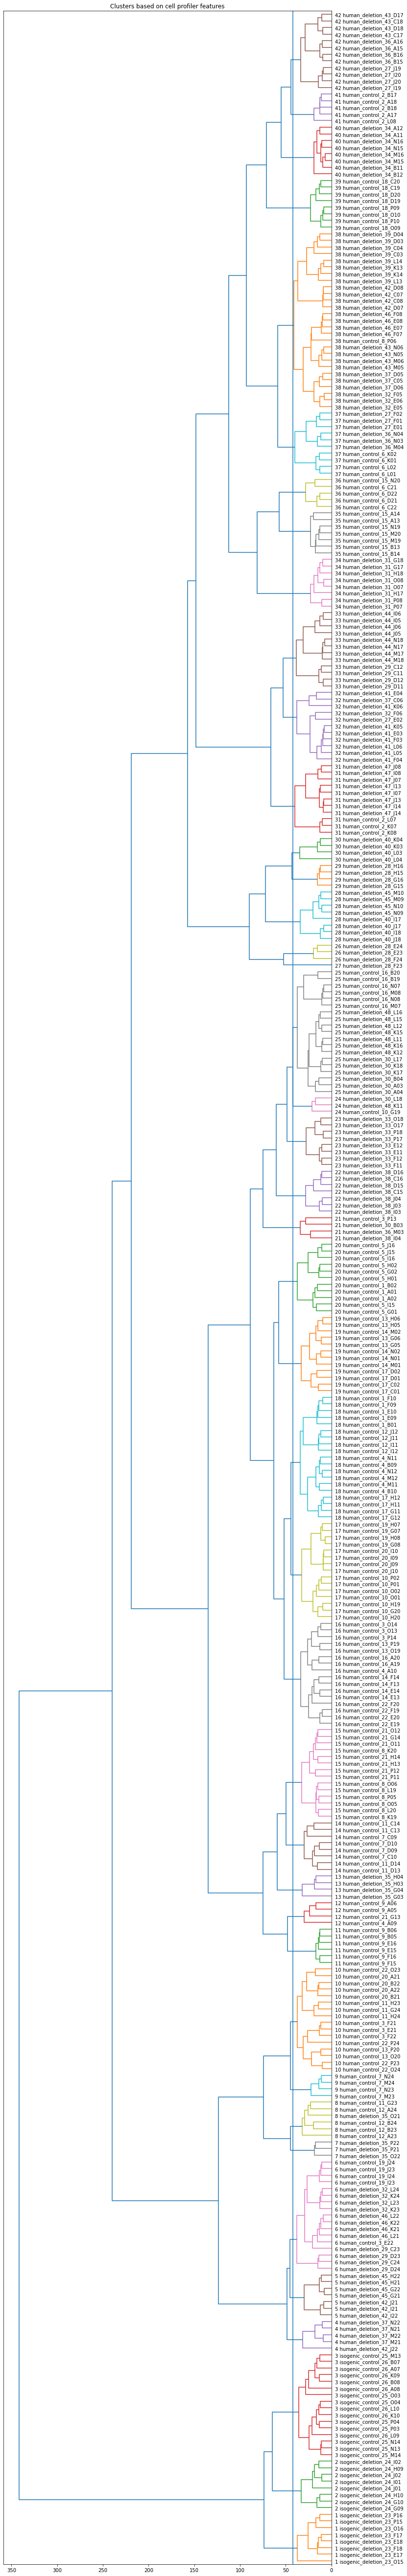

In [14]:
clusters = hierarchical_cluster(data_by_well, 42, show=True)

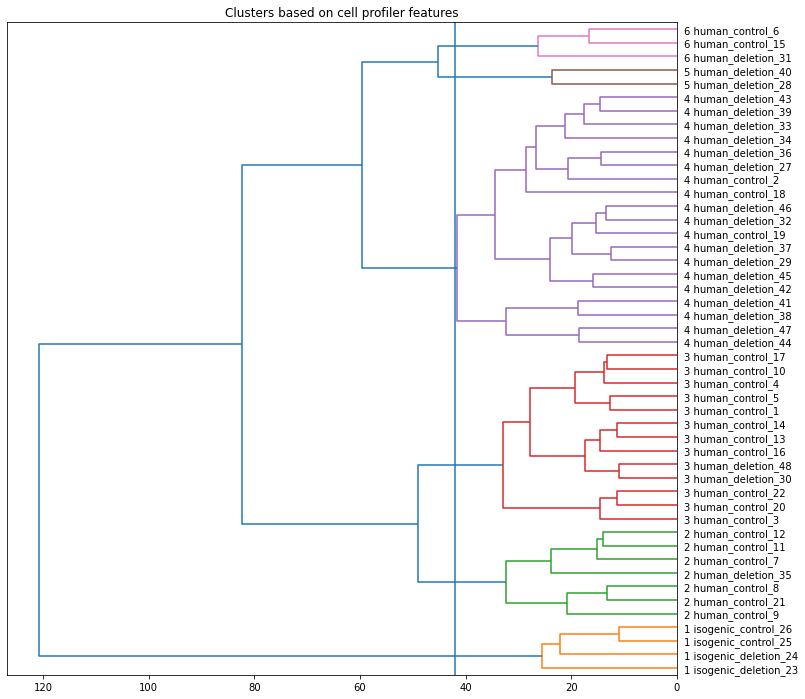

In [15]:
clusters1 = hierarchical_cluster(data_by_line, 42, show=True)

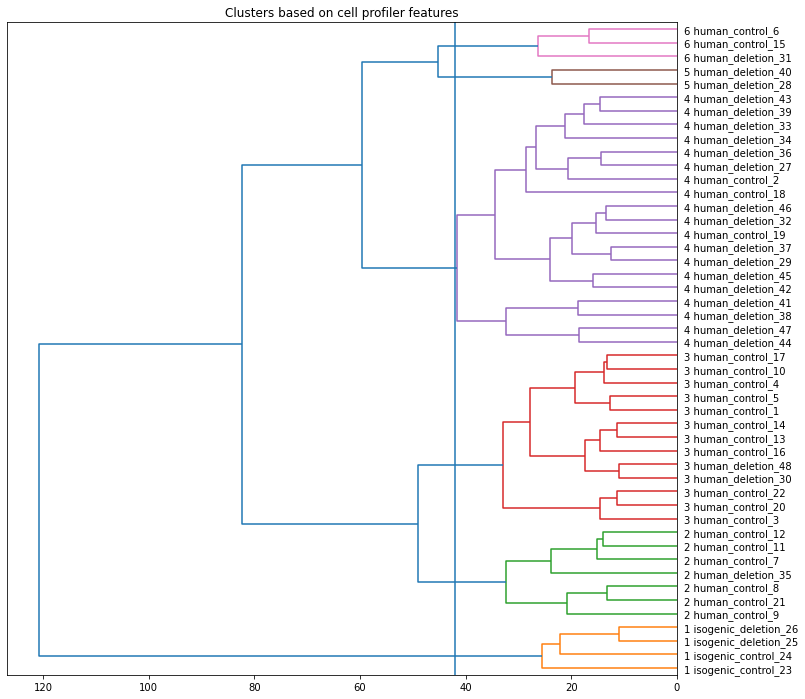

In [16]:
data_by_line_orig = data_by_well_orig.copy()
data_by_line_orig['split'] = data_by_line_orig.index.str.split('_')
data_by_line_orig['perturb'] = [i[0] + '_' + i[1] + '_' + i[2] for i in data_by_line_orig['split']]
data_by_line_orig = data_by_line_orig.groupby(by='perturb').median()
clusters_no_exclude = hierarchical_cluster(data_by_line_orig, 42, show=True)

In [17]:
# Compare homogeneity score between the clusters with and without excluding outlier wells
clusters1['perturb'] = clusters1.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
print(homogeneity_score(clusters1['cluster_num'], clusters1['perturb']))
clusters_no_exclude['perturb'] = clusters_no_exclude.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
print(homogeneity_score(clusters_no_exclude['cluster_num'], clusters_no_exclude['perturb']))

0.35247471005455444
0.35247471005455444


# PCA

<AxesSubplot:xlabel='PC1', ylabel='PC2'>

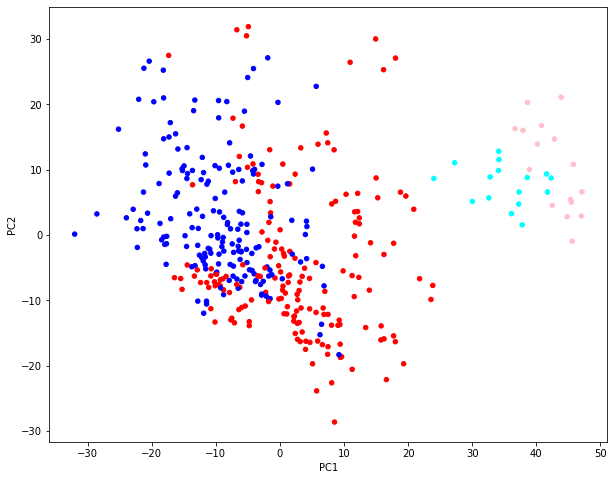

In [18]:
pca = PCA(n_components=2)
pca_fit = pca.fit(data_by_well)
pca_vals = pca_fit.transform(data_by_well)
pca_df = pd.DataFrame(pca_vals, columns=['PC1', 'PC2'], index=data_by_well.index)
idxs = [i.split('_')[0] + '_' + i.split('_')[1] for i in pca_df.index.tolist()]
idx2color = {'human_control': 'b', 'isogenic_control': 'cyan', 'human_deletion': 'r', 'isogenic_deletion': 'pink'}
colors = [idx2color[i] for i in idxs]
pca_df['color'] = colors

fig, ax = plt.subplots(figsize=(10,8))
pca_df.plot('PC1', 'PC2', kind='scatter', ax=ax, c='color')

# Differentiating features

In [19]:
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')]
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')]

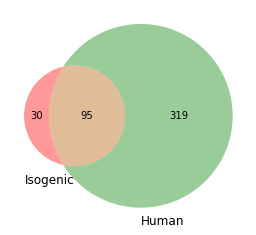

In [20]:
# Find features different between deletion and control in iso and human samples
iso_diff = ttest_2_df(iso_del, iso_ctrl, alpha=0.01, reject_only=True).sort_values(by='adj_p_value', ascending=True)
human_diff = ttest_2_df(human_del, human_ctrl, alpha=0.01, reject_only=True).sort_values(by='adj_p_value', ascending=True)

iso_only = [i for i in iso_diff.index.tolist() if i not in human_diff.index.tolist()]
human_only = [i for i in human_diff.index.tolist() if i not in iso_diff.index.tolist()]
shared = [i for i in iso_diff.index.tolist() if i in human_diff.index.tolist()]

venn2(subsets=(len(iso_only), len(human_only), len(shared)), set_labels=('Isogenic', 'Human'))

In [21]:
sorted(human_diff.index.tolist())

['Cells_AreaShape_Center_Y',
 'Cells_AreaShape_Compactness',
 'Cells_AreaShape_EulerNumber',
 'Cells_AreaShape_MaximumRadius',
 'Cells_AreaShape_Zernike_1_1',
 'Cells_AreaShape_Zernike_2_2',
 'Cells_AreaShape_Zernike_3_1',
 'Cells_AreaShape_Zernike_4_0',
 'Cells_AreaShape_Zernike_4_4',
 'Cells_AreaShape_Zernike_5_1',
 'Cells_AreaShape_Zernike_5_5',
 'Cells_AreaShape_Zernike_6_0',
 'Cells_AreaShape_Zernike_6_2',
 'Cells_AreaShape_Zernike_7_1',
 'Cells_AreaShape_Zernike_7_3',
 'Cells_AreaShape_Zernike_7_7',
 'Cells_AreaShape_Zernike_8_0',
 'Cells_AreaShape_Zernike_8_2',
 'Cells_AreaShape_Zernike_8_8',
 'Cells_AreaShape_Zernike_9_1',
 'Cells_AreaShape_Zernike_9_3',
 'Cells_AreaShape_Zernike_9_7',
 'Cells_AreaShape_Zernike_9_9',
 'Cells_Correlation_Correlation_AGP_Brightfield',
 'Cells_Correlation_Correlation_DNA_AGP',
 'Cells_Correlation_Correlation_DNA_ER',
 'Cells_Correlation_Correlation_DNA_RNA',
 'Cells_Correlation_Correlation_ER_AGP',
 'Cells_Correlation_Correlation_ER_Brightfield',


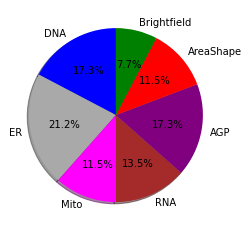

[18, 22, 12, 14, 18, 12, 8] 104


In [22]:
# Feature breakdown among features differentiating both isogenic and human
all_features = shared
dna_ch = [i for i in all_features if 'DNA' in i[-20:]]
er_ch = [i for i in all_features if 'ER' in i[-20:]]
mito_ch = [i for i in all_features if 'Mito' in i[-20:]]
rna_ch = [i for i in all_features if 'RNA' in i[-20:]]
agp_ch = [i for i in all_features if 'AGP' in i[-20:]]
areashape = [i for i in all_features if 'AreaShape' in i]
brightfield = [i for i in all_features if 'Brightfield' in i]
labels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'AreaShape', 'Brightfield']
sizes = [len(dna_ch), len(er_ch), len(mito_ch), len(rna_ch), len(agp_ch), len(areashape), len(brightfield)]

colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
        shadow=True, startangle=90)
plt.show()

print(sizes,sum(sizes))

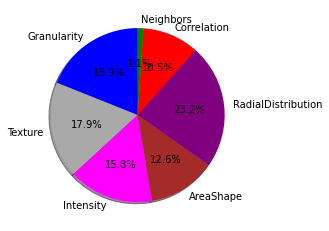

[18, 17, 15, 12, 22, 10, 1] 95


In [23]:
# Features by feature type for features differentiating both isogenic and human
all_features = shared
all_feature_types = [i.split('_')[1] for i in all_features]
all_feature_types = Counter(all_feature_types)
labels = []
sizes = []

fig1, ax1 = plt.subplots()
for x,y in all_feature_types.items():
    labels.append(x)
    sizes.append(y)
    
colors = ['b', 'darkgrey', 'magenta', 'brown', 'purple', 'r', 'g', 'orange']

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors,
        shadow=True, startangle=90)
plt.show()
print(sizes,sum(sizes))

In [24]:
# Look at difference between the control and deletion, for human and isogenic
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')]
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')]

human_del_ctrl_diff = human_del.median() - human_ctrl.median()
iso_del_ctrl_diff = iso_del.median() - iso_ctrl.median()

del_higher_both = []
del_lower_both = []
del_opposite_direction = []
for index, human_val in human_del_ctrl_diff.iteritems():
    iso_val = iso_del_ctrl_diff[index]
    if iso_val > 0 and human_val > 0:
        del_higher_both.append(index)
    elif iso_val < 0 and human_val < 0:
        del_lower_both.append(index)
    else:
        del_opposite_direction.append(index)

print('num features where deletion is higher in both iso and human: {}'.format(len(del_higher_both)))
print('num features where deletion is lower in both iso and human: {}'.format(len(del_lower_both)))
print('num features where deletion and control have opposite direction in iso and human: {}'.format(len(del_opposite_direction)))

num features where deletion is higher in both iso and human: 161
num features where deletion is lower in both iso and human: 155
num features where deletion and control have opposite direction in iso and human: 243


In [25]:
# Same as above, but look only at features which are significant in both isogenic and control
human_ctrl = data_by_well[data_by_well.index.str.contains('human_control')][shared]
iso_ctrl = data_by_well[data_by_well.index.str.contains('isogenic_control')][shared]
human_del = data_by_well[data_by_well.index.str.contains('human_deletion')][shared]
iso_del = data_by_well[data_by_well.index.str.contains('isogenic_deletion')][shared]

human_del_ctrl_diff = human_del.median() - human_ctrl.median()
iso_del_ctrl_diff = iso_del.median() - iso_ctrl.median()

del_higher_both = []
del_lower_both = []
del_opposite_direction = []
for index, human_val in human_del_ctrl_diff.iteritems():
    iso_val = iso_del_ctrl_diff[index]
    if iso_val > 0 and human_val > 0:
        del_higher_both.append(index)
    elif iso_val < 0 and human_val < 0:
        del_lower_both.append(index)
    else:
        del_opposite_direction.append(index)

print('num features where deletion is higher in both iso and human: {}'.format(len(del_higher_both)))
print('num features where deletion is lower in both iso and human: {}'.format(len(del_lower_both)))
print('num features where deletion and control have opposite direction in iso and human: {}'.format(len(del_opposite_direction)))

num features where deletion is higher in both iso and human: 43
num features where deletion is lower in both iso and human: 27
num features where deletion and control have opposite direction in iso and human: 25


In [26]:
data_by_line['group'] = data_by_line.index.str.split('_').map(lambda x: x[0] + '_' + x[1])
data_by_line.groupby(by='group').median()[shared]

,Nuclei_Granularity_2_AGP,Cells_Texture_Contrast_ER_10_00,Cytoplasm_Intensity_IntegratedIntensityEdge_ER,Cells_Intensity_IntegratedIntensityEdge_AGP,Cells_Intensity_IntegratedIntensityEdge_ER,Cells_Granularity_1_Mito,Cytoplasm_Intensity_MADIntensity_ER,Cytoplasm_AreaShape_Extent,Nuclei_Intensity_MassDisplacement_RNA,Nuclei_Texture_InfoMeas1_ER_10_00,...,Nuclei_Granularity_2_RNA,Cells_Texture_InfoMeas1_ER_20_01,Nuclei_Correlation_K_Mito_Brightfield,Nuclei_Texture_InfoMeas1_DNA_5_00,Cells_AreaShape_MaximumRadius,Cells_RadialDistribution_FracAtD_ER_4of4,Cytoplasm_Texture_Correlation_DNA_10_00,Cells_RadialDistribution_MeanFrac_Brightfield_4of4,Cytoplasm_RadialDistribution_FracAtD_DNA_4of4,Cells_RadialDistribution_FracAtD_AGP_4of4
group,,,,,,,,,,,,,,,,,,,,,
human_control,0.598423,0.526548,-0.375642,-0.267615,-0.532488,-0.284017,-0.708130,0.240932,0.409282,-0.520490,...,-0.217308,0.035787,-0.378683,-0.287455,0.269509,-0.463970,-0.428120,0.331697,0.390805,-0.601345
human_deletion,-0.371735,-0.366347,0.374705,0.332540,0.495900,0.503910,0.478095,-0.043482,-0.302780,0.389682,...,0.013555,-0.199548,0.135910,0.404110,-0.407230,0.418645,0.205267,-0.085386,-0.494480,0.456540
isogenic_control,-0.785510,-1.126488,3.263925,2.800500,3.997125,0.598807,-0.101304,-2.310825,-1.699850,2.369375,...,1.375550,2.100550,1.550950,1.599075,1.009537,3.041450,2.630925,-3.907125,-2.429875,2.673350
isogenic_deletion,0.083419,-1.859775,4.442200,4.801025,5.315975,1.912550,-0.789875,-1.374853,-2.157500,2.865850,...,2.398275,2.918525,2.198875,1.886725,2.429587,3.265125,3.043525,-4.304075,-2.995500,2.897725


In [27]:
print(len(del_opposite_direction) + len(del_higher_both) + len(del_lower_both))
[i for i in del_opposite_direction if 'Granu' in i or 'Tex' in i]
# del_higher_both
# del_lower_both

95


['Nuclei_Granularity_2_AGP',
 'Nuclei_Granularity_2_ER',
 'Cells_Texture_InverseDifferenceMoment_ER_10_00',
 'Nuclei_Granularity_2_DNA',
 'Cytoplasm_Texture_InfoMeas1_RNA_10_01',
 'Cytoplasm_Texture_Correlation_AGP_10_00',
 'Cells_Texture_SumAverage_ER_10_00',
 'Cells_Texture_Correlation_AGP_10_00',
 'Nuclei_Granularity_8_DNA',
 'Cells_Texture_InfoMeas1_ER_20_01']

In [28]:
def get_feature_type_count(list_of_features, categories):
    """
    Returns dictionary of counts to feature category
    Note that if the categories are channels instead of feature types, the features of 2 channels will be double counted.
    """
    counts = {}
    for cat in categories:
        features = [i for i in list_of_features if cat in i]
        counts[cat] = len(features)
    return counts

categories = ['Texture', 'Granularity', 'Intensity', 'RadialDistribution', 'AreaShape', 'Correlation']   
channels = ['DNA', 'ER', 'Mito', 'RNA', 'AGP', 'Brightfield', 'AreaShape']
# get_feature_type_count(del_opposite_direction, categories)    
# get_feature_type_count(del_opposite_direction, channels)    
# get_feature_type_count(del_higher_both, categories)    
get_feature_type_count(del_higher_both, channels) 
# get_feature_type_count(del_lower_both, categories)    
# get_feature_type_count(del_lower_both, channels) 
# get_feature_type_count(data_by_well.columns.tolist(), categories)  
# get_feature_type_count(data_by_well.columns.tolist(), channels)  

{'DNA': 10,
 'ER': 11,
 'Mito': 5,
 'RNA': 8,
 'AGP': 3,
 'Brightfield': 3,
 'AreaShape': 8}

# Differential feature analysis

In [29]:
sorted(del_higher_both) 
# del_lower_both 
# del_opposite_direction 

['Cells_AreaShape_Zernike_5_5',
 'Cells_AreaShape_Zernike_7_7',
 'Cells_AreaShape_Zernike_9_9',
 'Cells_Correlation_K_ER_Brightfield',
 'Cells_Correlation_K_Mito_Brightfield',
 'Cells_Correlation_Overlap_DNA_ER',
 'Cells_Correlation_Overlap_DNA_RNA',
 'Cells_Granularity_1_AGP',
 'Cells_Granularity_1_Mito',
 'Cells_Intensity_IntegratedIntensityEdge_AGP',
 'Cells_Intensity_IntegratedIntensityEdge_DNA',
 'Cells_Intensity_IntegratedIntensityEdge_ER',
 'Cells_Intensity_IntegratedIntensity_DNA',
 'Cells_Intensity_IntegratedIntensity_ER',
 'Cells_Neighbors_AngleBetweenNeighbors_10',
 'Cells_RadialDistribution_FracAtD_AGP_4of4',
 'Cells_RadialDistribution_FracAtD_ER_4of4',
 'Cells_RadialDistribution_FracAtD_RNA_4of4',
 'Cytoplasm_AreaShape_Zernike_5_5',
 'Cytoplasm_AreaShape_Zernike_7_5',
 'Cytoplasm_AreaShape_Zernike_7_7',
 'Cytoplasm_AreaShape_Zernike_9_9',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_DNA',
 'Cytoplasm_Intensity_IntegratedIntensityEdge_ER',
 'Cytoplasm_Intensity_IntegratedI

In [30]:
sorted(del_lower_both) 

['Cells_Correlation_K_Brightfield_Mito',
 'Cells_Granularity_10_AGP',
 'Cells_Granularity_1_Brightfield',
 'Cells_Granularity_4_AGP',
 'Cells_Granularity_5_AGP',
 'Cells_Intensity_MADIntensity_Mito',
 'Cells_Intensity_MaxIntensity_ER',
 'Cells_RadialDistribution_FracAtD_DNA_3of4',
 'Cells_RadialDistribution_FracAtD_RNA_1of4',
 'Cells_RadialDistribution_FracAtD_RNA_3of4',
 'Cells_RadialDistribution_MeanFrac_Brightfield_4of4',
 'Cells_Texture_Contrast_ER_10_00',
 'Cells_Texture_Contrast_Mito_10_00',
 'Cells_Texture_InfoMeas2_ER_20_01',
 'Cytoplasm_Granularity_4_AGP',
 'Cytoplasm_Granularity_5_AGP',
 'Cytoplasm_RadialDistribution_FracAtD_DNA_4of4',
 'Cytoplasm_RadialDistribution_FracAtD_Mito_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_ER_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_Mito_1of4',
 'Cytoplasm_RadialDistribution_MeanFrac_RNA_1of4',
 'Cytoplasm_Texture_InfoMeas1_DNA_10_00',
 'Nuclei_Correlation_Correlation_Mito_ER',
 'Nuclei_Granularity_10_AGP',
 'Nuclei_Granularity_9_AGP'

In [31]:
sorted(del_opposite_direction)

['Cells_AreaShape_MaximumRadius',
 'Cells_Correlation_Overlap_DNA_AGP',
 'Cells_Intensity_MeanIntensity_ER',
 'Cells_Intensity_MedianIntensity_Mito',
 'Cells_Texture_Correlation_AGP_10_00',
 'Cells_Texture_InfoMeas1_ER_20_01',
 'Cells_Texture_InverseDifferenceMoment_ER_10_00',
 'Cells_Texture_SumAverage_ER_10_00',
 'Cytoplasm_AreaShape_Extent',
 'Cytoplasm_Intensity_MADIntensity_ER',
 'Cytoplasm_RadialDistribution_MeanFrac_Brightfield_3of4',
 'Cytoplasm_Texture_Correlation_AGP_10_00',
 'Cytoplasm_Texture_InfoMeas1_RNA_10_01',
 'Nuclei_AreaShape_Zernike_2_0',
 'Nuclei_AreaShape_Zernike_6_2',
 'Nuclei_Correlation_Overlap_AGP_Brightfield',
 'Nuclei_Granularity_2_AGP',
 'Nuclei_Granularity_2_DNA',
 'Nuclei_Granularity_2_ER',
 'Nuclei_Granularity_8_DNA',
 'Nuclei_Intensity_MassDisplacement_AGP',
 'Nuclei_RadialDistribution_RadialCV_AGP_1of4',
 'Nuclei_RadialDistribution_RadialCV_AGP_3of4',
 'Nuclei_RadialDistribution_RadialCV_DNA_1of4',
 'Nuclei_RadialDistribution_RadialCV_DNA_2of4']